In [1]:
import os
import time
import copy
import pickle
import urllib
import datetime
from tqdm import tqdm_notebook, tqdm
from collections import Counter

from astropy.io import fits
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torchvision.models.resnet import BasicBlock
from torch.optim import lr_scheduler

import pretrainedmodels

from sklearn.metrics import f1_score
from skimage.transform import resize, rescale
from sklearn.utils import class_weight

import warnings
# import cv2

plt.ion()
warnings.filterwarnings("ignore")

In [2]:
url_pkl = 'https://raw.githubusercontent.com/iknyazeva/FitsProcessing/master/sunspot_1996_2017.pkl'
dataset_folder = 'HMIdataset/fragments/'
with urllib.request.urlopen(url_pkl) as pkl:
    sunspots = pickle.load(pkl)

distributions_classes = Counter([class_ for class_ in sunspots['class']])
distributions_classes1 = Counter([class_[0] for class_ in sunspots['class']])
distributions_classes2 = Counter([class_[1] for class_ in sunspots['class']])
distributions_classes3 = Counter([class_[2] for class_ in sunspots['class']])

In [270]:
distributions_classes
# distributions_classes1
# distributions_classes2
# distributions_classes3

Counter({'AXX': 3302,
         'BXO': 3933,
         'CRO': 1407,
         'DSO': 2280,
         'DAO': 2844,
         'CAO': 2053,
         'HSX': 4671,
         'CSO': 3255,
         'HRX': 736,
         'CRI': 32,
         'DAI': 957,
         'EAC': 179,
         'EHI': 63,
         'EHO': 66,
         'ESI': 137,
         'EKI': 426,
         'ESO': 358,
         'DSI': 244,
         'EKC': 516,
         'DRO': 311,
         'EAI': 577,
         'EAO': 673,
         'HAX': 1395,
         'DRI': 26,
         'FSI': 26,
         'DKO': 262,
         'FKI': 199,
         'EKO': 210,
         'FKO': 95,
         'HKX': 142,
         'HHX': 155,
         'FKC': 363,
         'FSC': 6,
         'FHI': 15,
         'CHO': 118,
         'ESC': 19,
         'CKO': 188,
         'FAI': 156,
         'FHO': 26,
         'DHO': 105,
         'DAC': 212,
         'FHC': 23,
         'FAO': 105,
         'DKI': 250,
         'CKI': 14,
         'BXI': 19,
         'CAI': 112,
         'DSC': 27

In [4]:
label_wts = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique([class_[0] for class_ in sunspots['class']]), y=[class_[0] for class_ in sunspots['class']])
print(label_wts)

print(sorted(distributions_classes1.items()))

np.unique([class_[0] for class_ in sunspots['class']])

[1.46019728 1.22003326 0.66716085 0.61862605 1.48173676 4.30113419
 0.67899893]
[('A', 3302), ('B', 3952), ('C', 7227), ('D', 7794), ('E', 3254), ('F', 1121), ('H', 7101)]


array(['A', 'B', 'C', 'D', 'E', 'F', 'H'], dtype='<U1')

In [ ]:
from sklearn import metrics

clf.fit(X[train_idx], y[train_idx])
y_preds = clf.predict(X[test_idx])

# --classification report --
metrics.classification_report(y[test_idx], y_preds, labels=[0,1])

#              precision    recall  f1-score   support

#           0       0.98      1.00      0.99       610
#           1       0.25      0.08      0.12        12

# avg / total       0.97      0.98      0.97       622

In [5]:
print(f'pidor: {label_wts}')

pidor: [1.46019728 1.22003326 0.66716085 0.61862605 1.48173676 4.30113419
 0.67899893]


In [43]:
# torch.reshape(torch.Tensor(label_wts)
np.repeat(label_wts.reshape(1,-1), 3, axis=0)
# label_wts.reshape(1,7)

array([[1.46019728, 1.22003326, 0.66716085, 0.61862605, 1.48173676,
        4.30113419, 0.67899893],
       [1.46019728, 1.22003326, 0.66716085, 0.61862605, 1.48173676,
        4.30113419, 0.67899893],
       [1.46019728, 1.22003326, 0.66716085, 0.61862605, 1.48173676,
        4.30113419, 0.67899893]])

# EDA

In [18]:
import seaborn as sb
plt.rcParams['figure.figsize'] = (30,20)
sb.set()

In [3]:
sunspots.head()

number_of_ss size class location magn_class
date       region                                            
1996-06-04 7968              3    0   AXX   N02E41          A
1996-06-05 7968              2   10   BXO   N02E28          B
           7969              1    0   AXX   N09W33          A
1996-06-06 7968              4   20   CRO   N03E12          B
           7969              4   10   BXO   N08W44          B

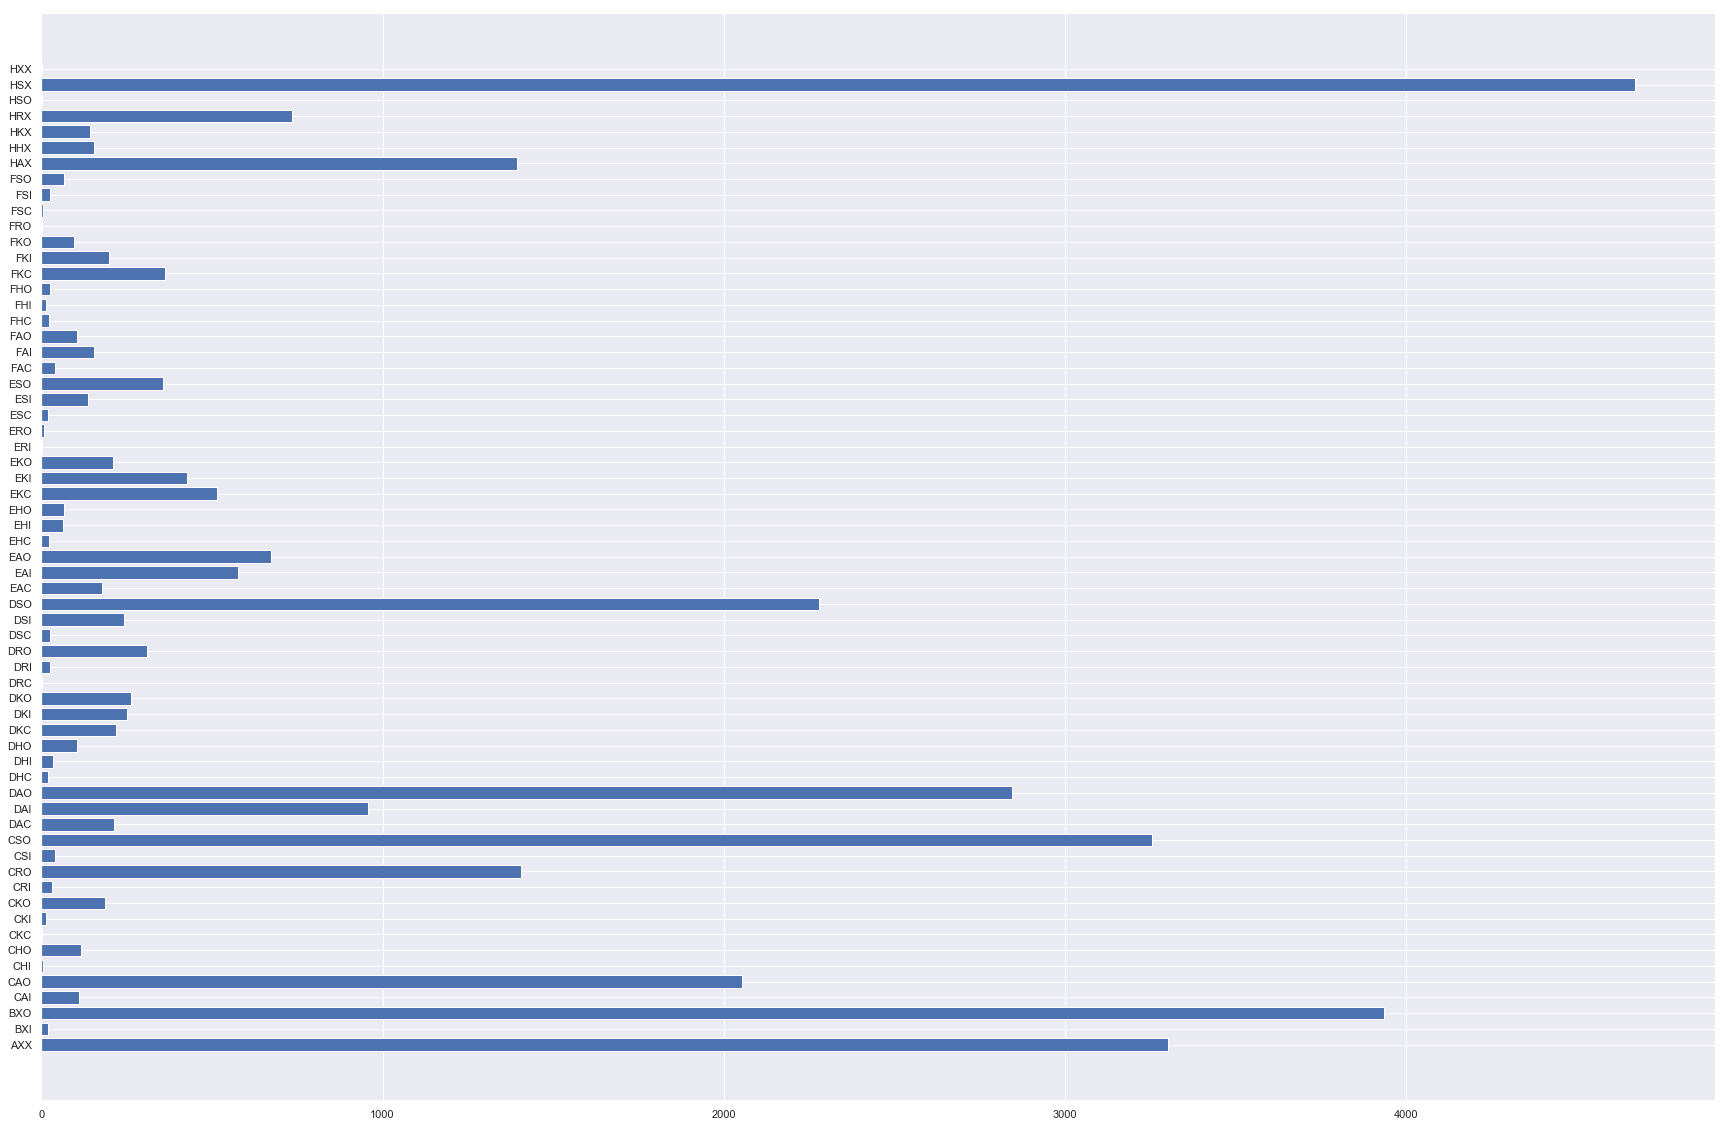

In [20]:
q, w = zip(*(sorted(distributions_classes.items())))
plt.barh(q, w)
plt.savefig('all_classes.png')

In [7]:
# a, b = zip(distributions_classes.items())
a, b = zip(*distributions_classes1.items())

<BarContainer object of 7 artists>

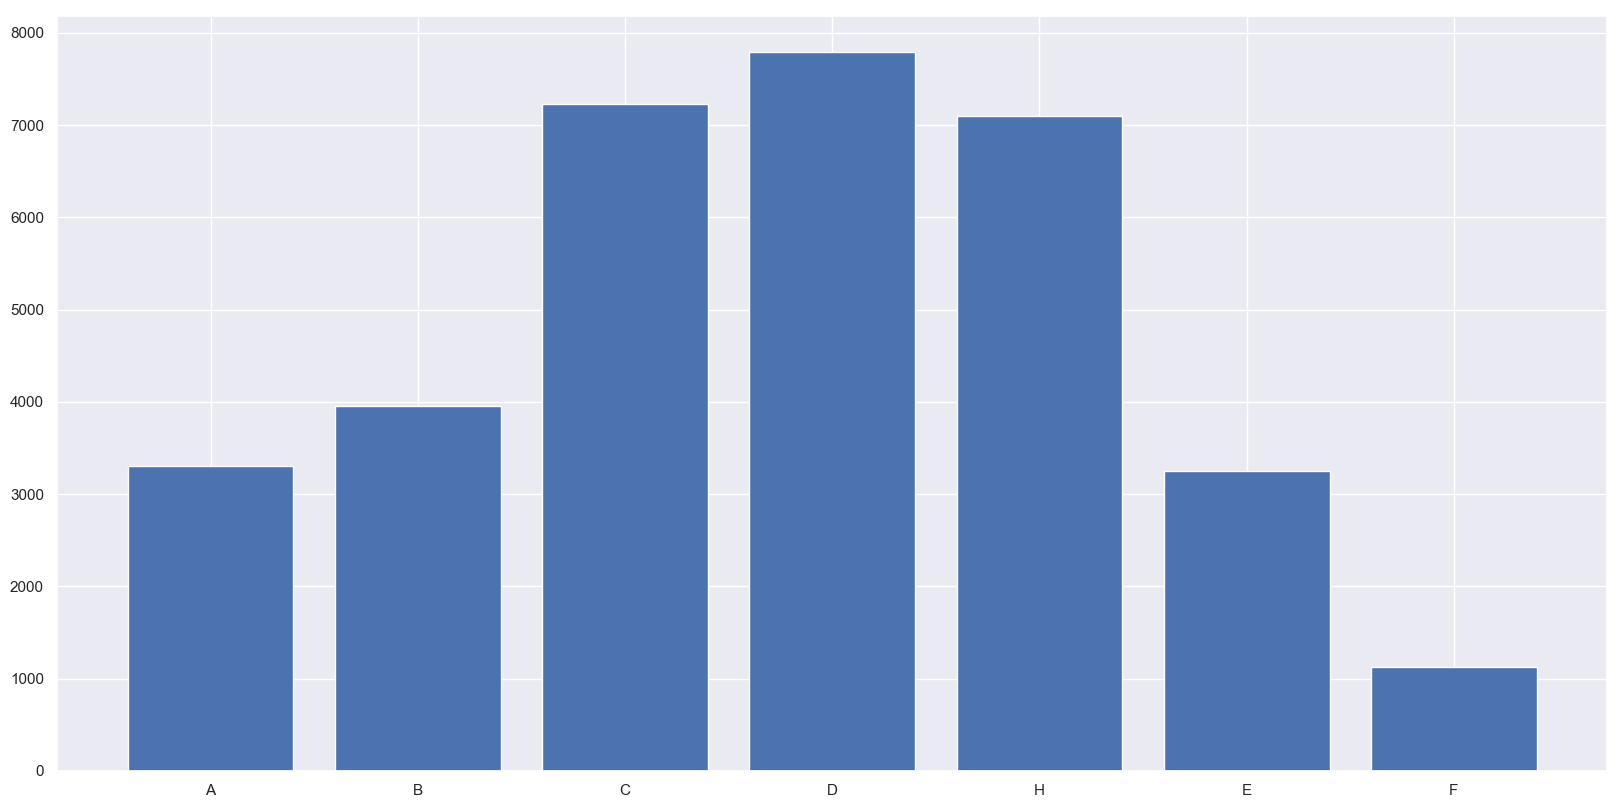

In [220]:
plt.bar(a, b)

In [261]:
zip(*sorted(distributions_classes.items()))

In [261]:
size_distr = Counter(size for size in sunspots['size'])
r, c =  zip(*size_distr.items())

In [ ]:
sunspots

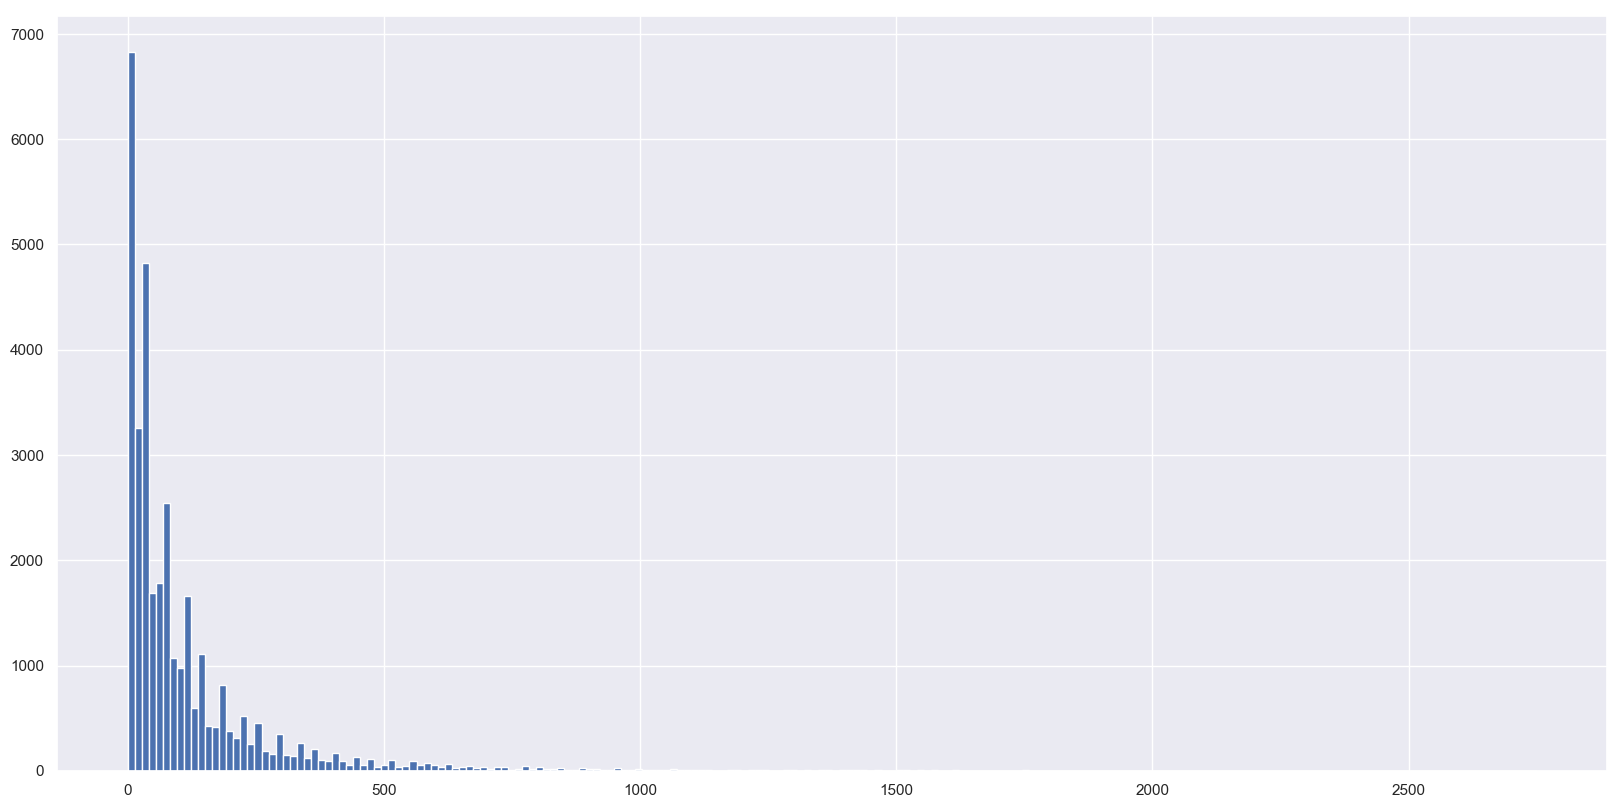

In [260]:
ern = [int(e) for e in er]
plt.hist(ern, bins=200);

In [287]:
dist_over_Z = {}
for letter in distributions_classes1:
    dist_over_Z[letter] = Counter([class_ for class_ in sunspots['class'] if class_[0]==letter])
dist_over_Z


{'A': Counter({'AXX': 3302}),
 'B': Counter({'BXO': 3933, 'BXI': 19}),
 'C': Counter({'CRO': 1407,
          'CAO': 2053,
          'CSO': 3255,
          'CRI': 32,
          'CHO': 118,
          'CKO': 188,
          'CKI': 14,
          'CAI': 112,
          'CHI': 6,
          'CSI': 41,
          'CKC': 1}),
 'D': Counter({'DSO': 2280,
          'DAO': 2844,
          'DAI': 957,
          'DSI': 244,
          'DRO': 311,
          'DRI': 26,
          'DKO': 262,
          'DHO': 105,
          'DAC': 212,
          'DKI': 250,
          'DSC': 27,
          'DKC': 220,
          'DHI': 35,
          'DHC': 20,
          'DRC': 1}),
 'H': Counter({'HSX': 4671,
          'HRX': 736,
          'HAX': 1395,
          'HKX': 142,
          'HHX': 155,
          'HXX': 1,
          'HSO': 1}),
 'E': Counter({'EAC': 179,
          'EHI': 63,
          'EHO': 66,
          'ESI': 137,
          'EKI': 426,
          'ESO': 358,
          'EKC': 516,
          'EAI': 577,
          'EA

1e-07